# <a id='toc1_'></a>[T23 State Space Control](#toc0_)

**Table of contents**<a id='toc0_'></a>    
- [T23 State Space Control](#toc1_)    
  - [DOFB](#toc1_1_)    
- [Combined estimator/regulator design for a simple system](#toc2_)    
  - [DOFB Example 1](#toc2_1_)    
  - [DOFB Example 2](#toc2_2_)    
  - [DOFB Example 3](#toc2_3_)    
  - [DOFB Example 4](#toc2_4_)    

<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

In [1]:
import requests as req, os

URL = "https://raw.githubusercontent.com/mit-acl/16_06_Class/main/"
File = ["basic_material.py","control_materials.py"]

if not os.path.isfile(File[0]):
    print('Basic files not` found - downloading it')
    for dfile in File:
        if not os.path.isfile(dfile):
            print(dfile)
            res = req.get(URL+dfile)
            file = open(dfile, 'w')
            file.write(res.text)
            file.close()
else:
    print('Basic file found')
from basic_material import *

j = complex(0,1)

from scipy.optimize import minimize
from scipy.signal import butter,bessel
from control.matlab import tf, ss, ss2tf, step, place, rlocus, lqr, lsim, ssdata
from control_materials import *

Basic file found
Running Python: 3.12.8
Running Sympy: 1.13.3
Control Package Found
This is a library of basic functions for 16.06
This is a library of useful functions for the control systems in 16.06


## <a id='toc1_1_'></a>[DOFB](#toc0_)

In [2]:
a = np.array([[0, 1],[-1, -1]])
nx = np.shape(a)[0]
b = np.array([0, 1]).reshape(nx,1)
c = np.array([1, 0])
d = 0

j = complex(0,1)
pr = np.array([-4+4*j, -4-4*j])
pe = np.array([-10, -11])

k = place(a,b,pr);
l = place(a.transpose(),c.reshape(nx,1),pe)
l = l.reshape(nx,1)
#
# For state space for G_c(s)
#
ac = a-b@k-l*c
bc = l
cc = k
dc = 0


# <a id='toc2_'></a>[Combined estimator/regulator design for a simple system](#toc0_)
$$G= \frac{1}{(s^2+s+1)}$$


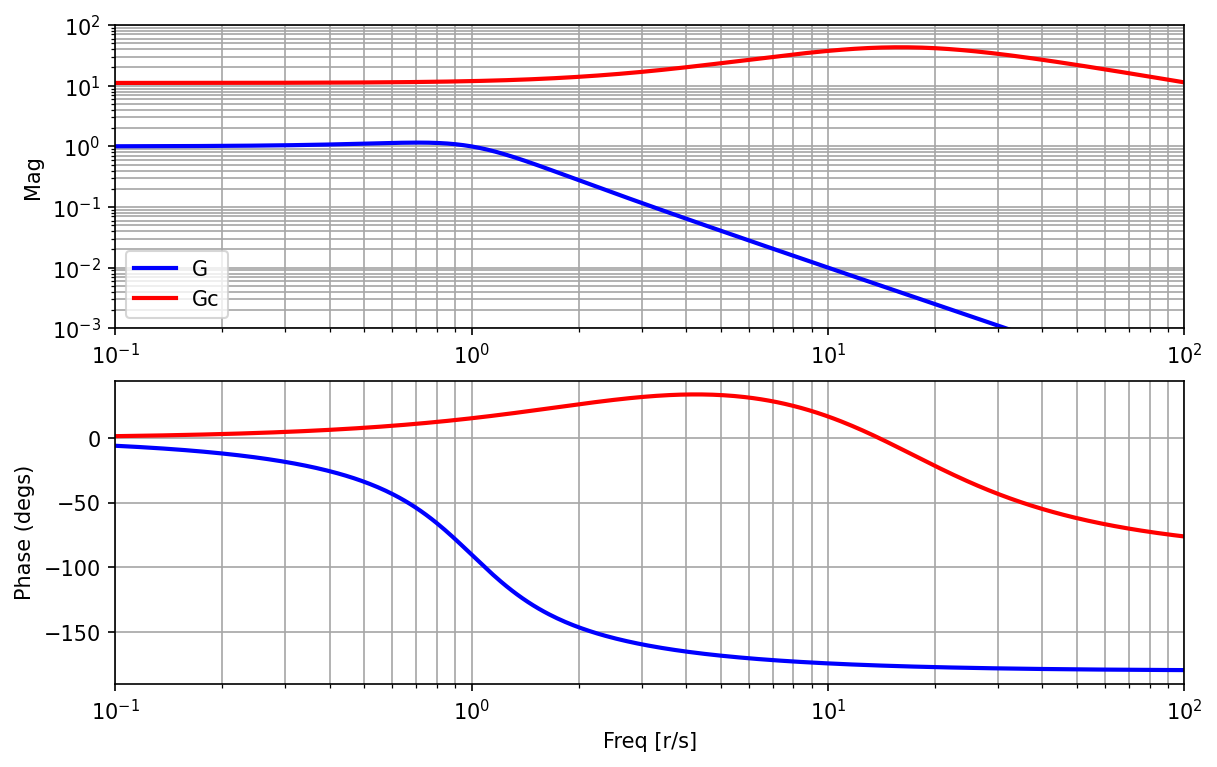

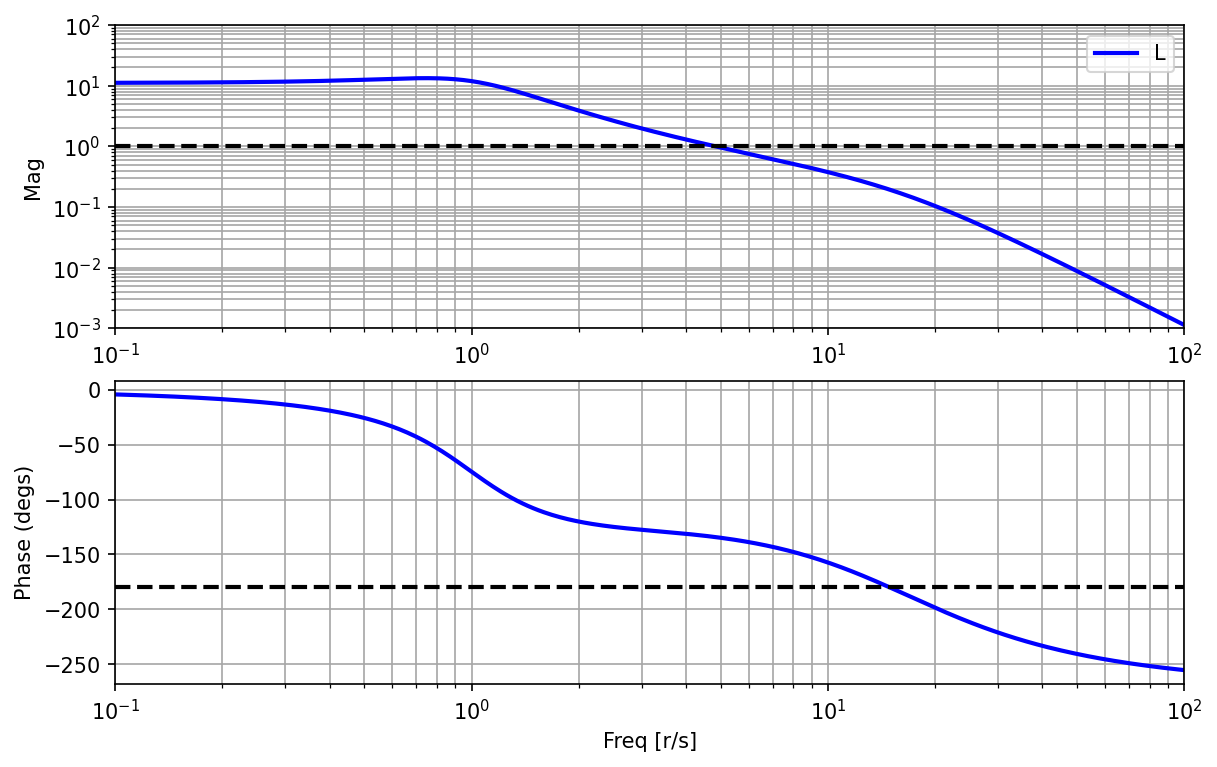

In [3]:
# System G
a = np.array([[0, 1],[-1, -1]])
nx = np.shape(a)[0]
b = np.array([0, 1]).reshape(nx,1)
c = np.array([1, 0])
d = 0

pr = np.array([-4+4*j, -4-4*j])
pe = np.array([-10.001, -10])

k = place(a,b,pr);
l = place(a.transpose(),c.reshape(nx,1),pe)
l = l.reshape(nx,1)
#
# For state space for G_c(s)
ac = a-b*k-l*c
bc = l
cc = k
dc = 0

G = ss(a,b,c,d)
Gc = ss(ac,bc,cc,dc)
L = G*Gc

w = np.logspace(-1,2,400)
Gf = G(w*j)
Gcf = Gc(j*w)
Lf = L(j*w)

fig, ax = plt.subplots(2,1,figsize=(8, 5),dpi=150,constrained_layout = True)
ax[0].loglog(w,np.abs(Gf),'b',label=r'G')
ax[1].semilogx(w,np.unwrap(np.angle(Gf))*r2d,'b',label=r'G')
ax[0].loglog(w,np.abs(Gcf),'r',label=r'Gc')
ax[1].semilogx(w,np.unwrap(np.angle(Gcf))*r2d,'r',label=r'Gc')
ax[1].set_xlabel('Freq [r/s]')
ax[0].set_ylabel('Mag')
ax[1].set_ylabel('Phase (degs)')
ax[0].grid(True, which="both", ls="-",color='0.65')
ax[1].grid(True, which="both", ls="-",color='0.65')
ax[0].legend()
ax[0].set_ylim(1e-3,100)
ymax = np.max([np.max(np.abs(Gf)),np.max(np.abs(Gcf))])
ymax = 10**np.ceil(np.log10(1.5*ymax))
ax[0].set_ylim(1e-3,ymax)
savefig("figs/DOFB0.pdf", dpi=600)
plt.show()

fig, ax = plt.subplots(2,1,figsize=(8, 5),dpi=150,constrained_layout = True)
ax[0].loglog(w,np.abs(Lf),'b',label=r'L')
ax[1].semilogx(w,np.unwrap(np.angle(Lf))*r2d,'b',label=r'L')
ax[1].set_xlabel('Freq [r/s]')
ax[0].set_ylabel('Mag')
ax[1].set_ylabel('Phase (degs)')
ax[0].grid(True, which="both", ls="-",color='0.65')
ax[1].grid(True, which="both", ls="-",color='0.65')
ax[0].axhline(y=1,c='k',ls='--')
ax[1].axhline(y=-180,c='k',ls='--')
ax[0].legend()
ax[0].set_ylim(1e-3,100)
savefig("figs/DOFB1.pdf", dpi=600)
plt.show()


Found breakin/out at K = 1.000
At possible locations s = 


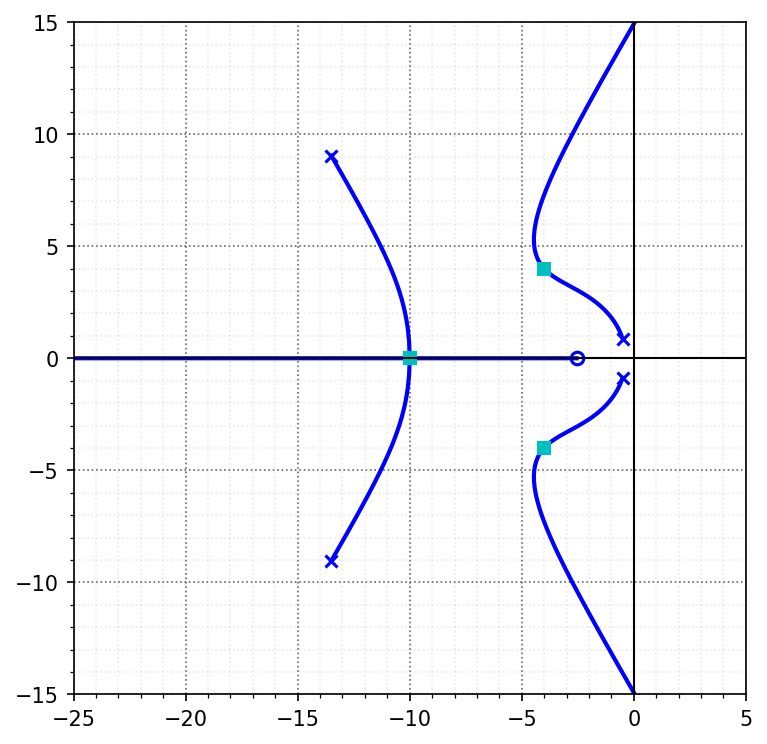

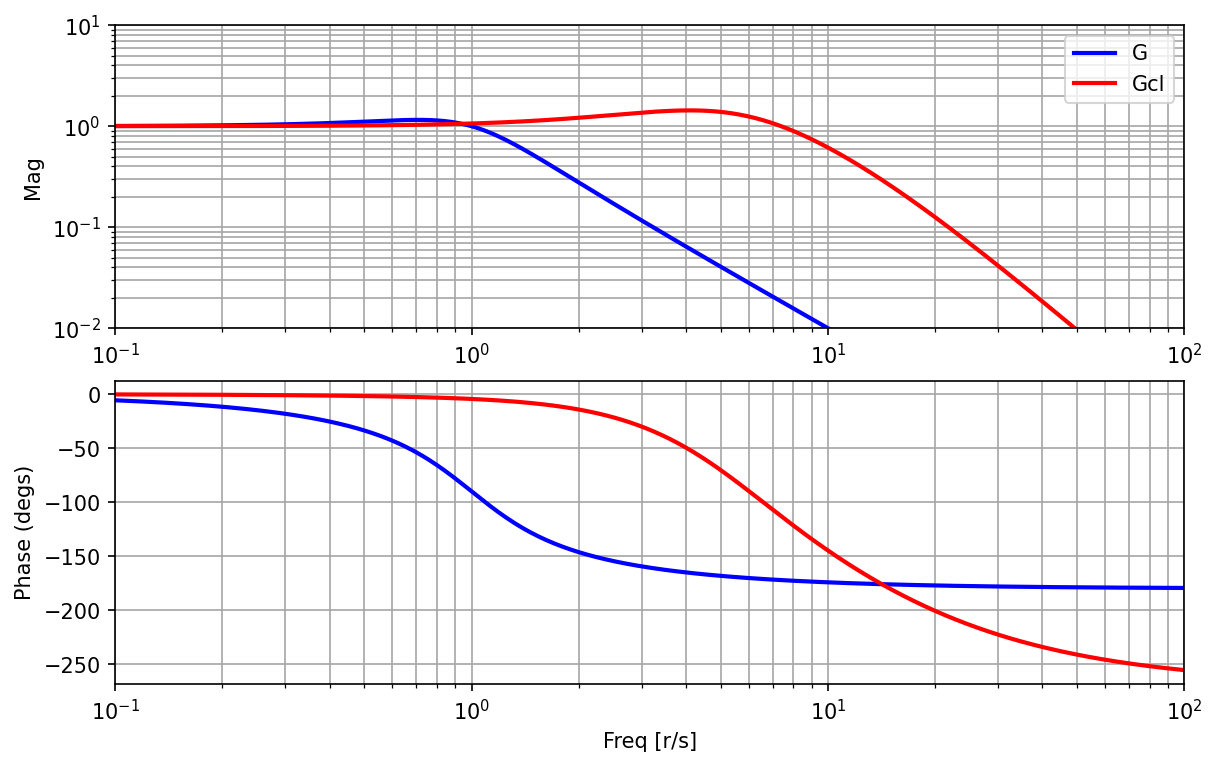

In [4]:
#
# loop dynamics L = G Gc
#
al = np.vstack((np.hstack((a,b*cc)),np.hstack((np.zeros((nx,nx)),ac))))
bl = np.vstack((np.zeros((nx,1)), bc ))
cl = np.hstack((c.reshape(1,nx), np.zeros((1,nx)) ))
dl = 0
L = ss2tf(al,bl,cl,dl)
#
# closed-loop dynamics
# unity gain wrapped around loop L
#
acl = al - bl*cl
bcl = bl 
ccl = cl
dcl = d
# scale closed-loop to get zero SS error
N = np.linalg.inv(np.dot(ccl,np.dot(np.linalg.inv(-acl),bcl)))
Gcl = near_zero(ss2tf(acl,bcl*N,ccl,dcl*N))
scl = Gcl.poles()
Gclf = Gcl(j*w)

assert np.allclose(np.sort(np.abs(scl)), np.sort(np.abs(np.concatenate((pr, pe)))), atol=1e-2), "scl is not close to pr + pe"

fig, ax = plt.subplots(1,figsize=(5, 5),dpi=150,constrained_layout = True)
rlist, klist = rlocus(L, kvect=Root_Locus_gains(L), grid=False,ax=ax,color='b')
plt.plot(np.real(scl),np.imag(scl),'cs')
ax.set_aspect('equal')
ax.set_xlim([-25, 5]);
ax.set_ylim([-15, 15])
nicegrid(ax)
savefig("figs/DOFB2.pdf", dpi=600)
plt.show()

fig, ax = plt.subplots(2,1,figsize=(8, 5),dpi=150,constrained_layout = True)
ax[0].loglog(w,np.abs(Gf),'b',label=r'G')
ax[1].semilogx(w,np.unwrap(np.angle(Gf))*r2d,'b',label=r'G')
ax[0].loglog(w,np.abs(Gclf),'r',label=r'Gcl')
ax[1].semilogx(w,np.unwrap(np.angle(Gclf))*r2d,'r',label=r'Gcl')
ax[1].set_xlabel('Freq [r/s]')
ax[0].set_ylabel('Mag')
ax[1].set_ylabel('Phase (degs)')
ax[0].grid(True, which="both", ls="-",color='0.65')
ax[1].grid(True, which="both", ls="-",color='0.65')
ax[0].legend()
ax[0].set_ylim(1e-2,10)
savefig("figs/DOFB3.pdf", dpi=600)
plt.show()


In [5]:
def DOFB(G,pr,pe,file_name='temp',w=np.logspace(-1,2,400),use_y_lims=True):
    '''
    DOFB(G,pr,pe,file_name='temp',w=np.logspace(-1,2,400),use_y_lims=True)
    Design a state feedback controller for the system G(s) using pole placement.
    
    Inputs:
    G is a state space system
    pr is the desired closed-loop poles
    pe is the desired estimator poles
    file_name is the name of the file to save the figures
    w is the frequency vector for the Bode plots
    use_y_lims is a boolean to set the y-limits of the Bode plots

    Returns: 
    
    the state feedback gain k

    The function computes the state feedback gain k, the feedforward gain Nbar, and the closed-loop system Gcl.
    '''
    nx = G.A.shape[0]
    k = place(G.A,G.B,pr)
    l = (place(G.A.transpose(),G.C.reshape(nx,1),pe)).reshape(nx,1)
    #
    # For state space for G_c(s)
    #
    ac = G.A-G.B*k-l*G.C
    bc = l
    cc = k
    dc = 0
    Gc = ss(ac,bc,cc,dc)
    L = G*Gc

    Gf = G(w*j)
    Gcf = Gc(j*w)
    #
    # loop dynamics L = G Gc
    #
    al = np.vstack((np.hstack((G.A,G.B*cc)),np.hstack((np.zeros((nx,nx)),ac))))
    bl = np.vstack((np.zeros((nx,1)), bc ))
    cl = np.hstack((G.C.reshape(1,nx), np.zeros((1,nx)) ))
    dl = 0
    L = ss2tf(al,bl,cl,dl)
    Lf = L(j*w)
    #
    # closed-loop dynamics
    # unity gain wrapped around loop L
    #
    acl = al - bl*cl
    bcl = bl 
    ccl = cl
    dcl = d
    # scale closed-loop to get zero SS error
    N = np.linalg.inv(np.dot(ccl,np.dot(np.linalg.inv(-acl),bcl)))
    Gcl = ss2tf(acl,bcl*N,ccl,dcl*N)
    scl = Gcl.poles()
    Gclf = Gcl(j*w)
    
    assert np.allclose(np.sort(np.abs(scl)), np.sort(np.abs(np.concatenate((pr, pe)))), atol=1e-2), "scl is not close to pr + pe"

    fig, ax = plt.subplots(2,1,figsize=(8, 5),dpi=150,constrained_layout = True)
    ax[0].loglog(w,np.abs(Gf),'b',label=r'G')
    ax[1].semilogx(w,np.unwrap(np.angle(Gf))*r2d,'b',label=r'G')
    ax[0].loglog(w,np.abs(Gcf),'r',label=r'Gc')
    ax[1].semilogx(w,np.unwrap(np.angle(Gcf))*r2d,'r',label=r'Gc')
    ax[1].set_xlabel('Freq [r/s]')
    ax[0].set_ylabel('Mag')
    ax[1].set_ylabel('Phase (degs)')
    ax[0].grid(True, which="both", ls="-",color='0.65')
    ax[1].grid(True, which="both", ls="-",color='0.65')
    ax[0].legend()
    if use_y_lims:
        ymax = np.max((np.max(np.abs(Gf)),np.max(np.abs(Gcf))))
        ymax = 10**np.ceil(np.log10(1.5*ymax))
        ax[0].set_ylim(1e-3,ymax)

    savefig("figs/DOFB"+file_name+"_0.pdf", dpi=600)
    plt.show()

    fig, ax = plt.subplots(2,1,figsize=(8, 5),dpi=150,constrained_layout = True)
    ax[0].loglog(w,np.abs(Lf),'b',label=r'L')
    ax[1].semilogx(w,pshift(np.unwrap(np.angle(Lf)))*r2d,'b',label=r'L')
    test_val = np.mean(pshift(np.unwrap(np.angle(Lf)))*r2d)
    ax[1].set_xlabel('Freq [r/s]')
    ax[0].set_ylabel('Mag')
    ax[1].set_ylabel('Phase (degs)')
    ax[0].grid(True, which="both", ls="-",color='0.65')
    ax[1].grid(True, which="both", ls="-",color='0.65')
    ax[0].axhline(y=1,c='k',ls='--')
    if test_val < 0:
        ax[1].axhline(y=-180,c='k',ls='--')
    else:
        ax[1].axhline(y=180,c='k',ls='--')
    ax[0].legend()
    if use_y_lims:
        ymax = np.max((np.max(np.abs(Lf)),np.max(np.abs(Lf))))
        ymax = 10**np.ceil(np.log10(1.5*ymax))
        ax[0].set_ylim(1e-3,ymax)
    savefig("figs/DOFB"+file_name+"_1.pdf", dpi=600)
    plt.show()

    if 0:
        fig, ax = plt.subplots(1,figsize=(5, 5),dpi=150,constrained_layout = True)
        rlist, klist = rlocus(L, kvect=Root_Locus_gains(L), grid=False,ax=ax,color='b')
        plt.plot(np.real(scl),np.imag(scl),'cs')
        ax.set_aspect('equal')
        ax.set_xlim([-25, 5]);
        ax.set_ylim([-15, 15])
        nicegrid(ax)
        savefig("figs/DOFB"+file_name+"_2.pdf", dpi=600)
        plt.show()

    fig, ax = plt.subplots(2,1,figsize=(8, 5),dpi=150,constrained_layout = True)
    ax[0].loglog(w,np.abs(Gf),'b',label=r'G')
    ax[1].semilogx(w,np.unwrap(np.angle(Gf))*r2d,'b',label=r'G')
    ax[0].loglog(w,np.abs(Gclf),'r',label=r'Gcl')
    ax[1].semilogx(w,np.unwrap(np.angle(Gclf))*r2d,'r',label=r'Gcl')
    ax[1].set_xlabel('Freq [r/s]')
    ax[0].set_ylabel('Mag')
    ax[1].set_ylabel('Phase (degs)')
    ax[0].grid(True, which="both", ls="-",color='0.65')
    ax[1].grid(True, which="both", ls="-",color='0.65')
    ax[0].legend()
    if use_y_lims:
        ymax = np.max((np.max(np.abs(Gf)),np.max(np.abs(Gclf))))
        ymax = 10**np.ceil(np.log10(1.5*ymax))
        ax[0].set_ylim(1e-3,ymax)
        
    savefig("figs/DOFB"+file_name+"_3.pdf", dpi=600)
    plt.show()
    
    return Gc,Gcl

## <a id='toc2_1_'></a>[DOFB Example 1](#toc0_)

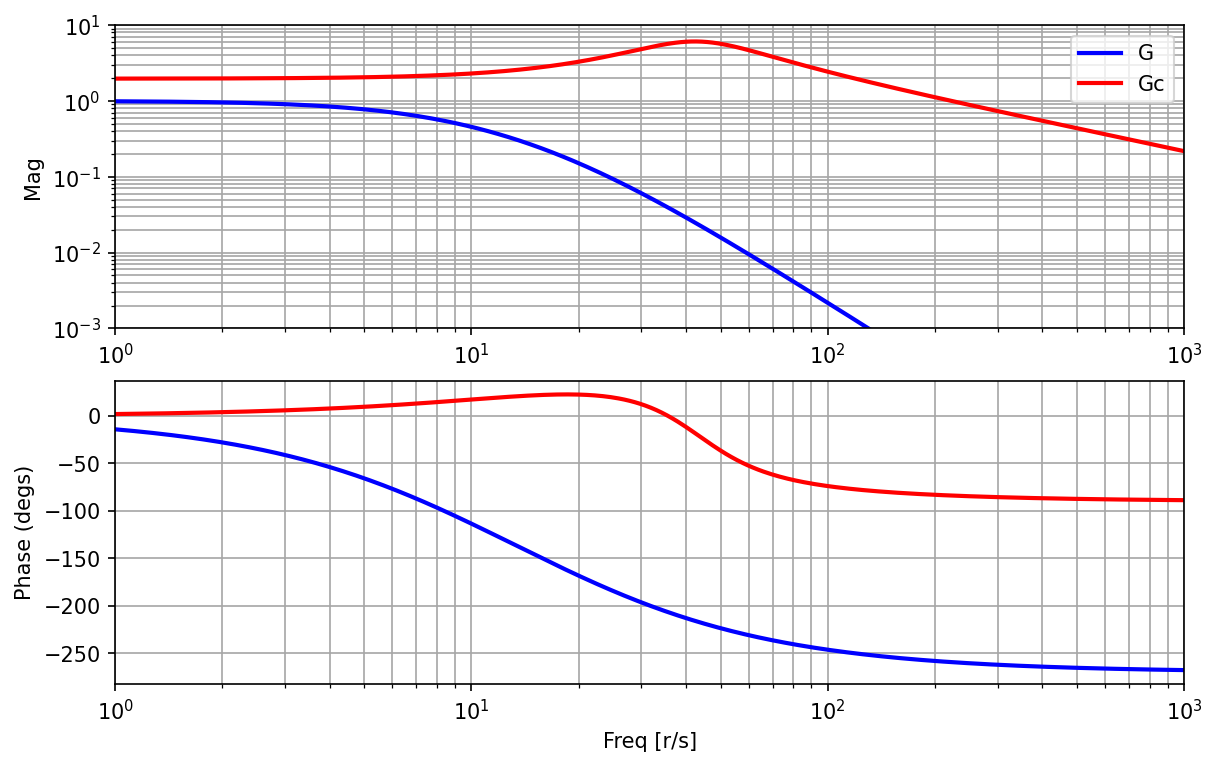

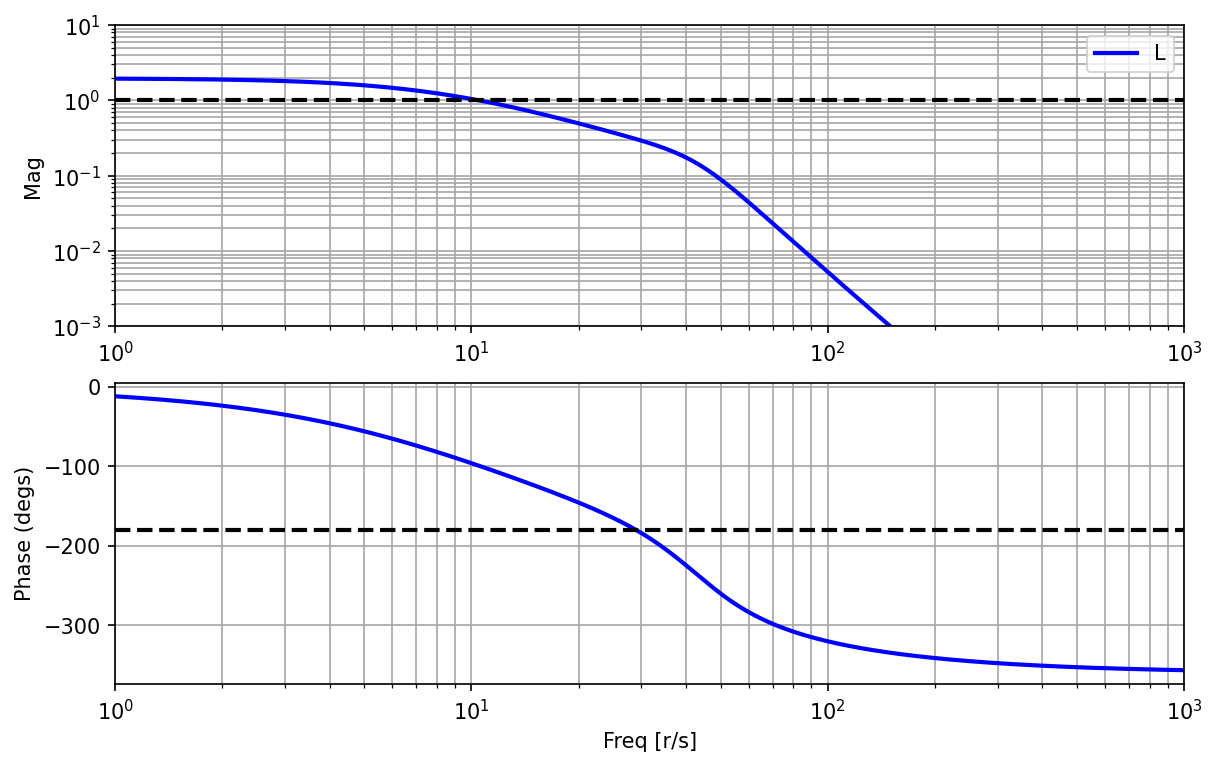

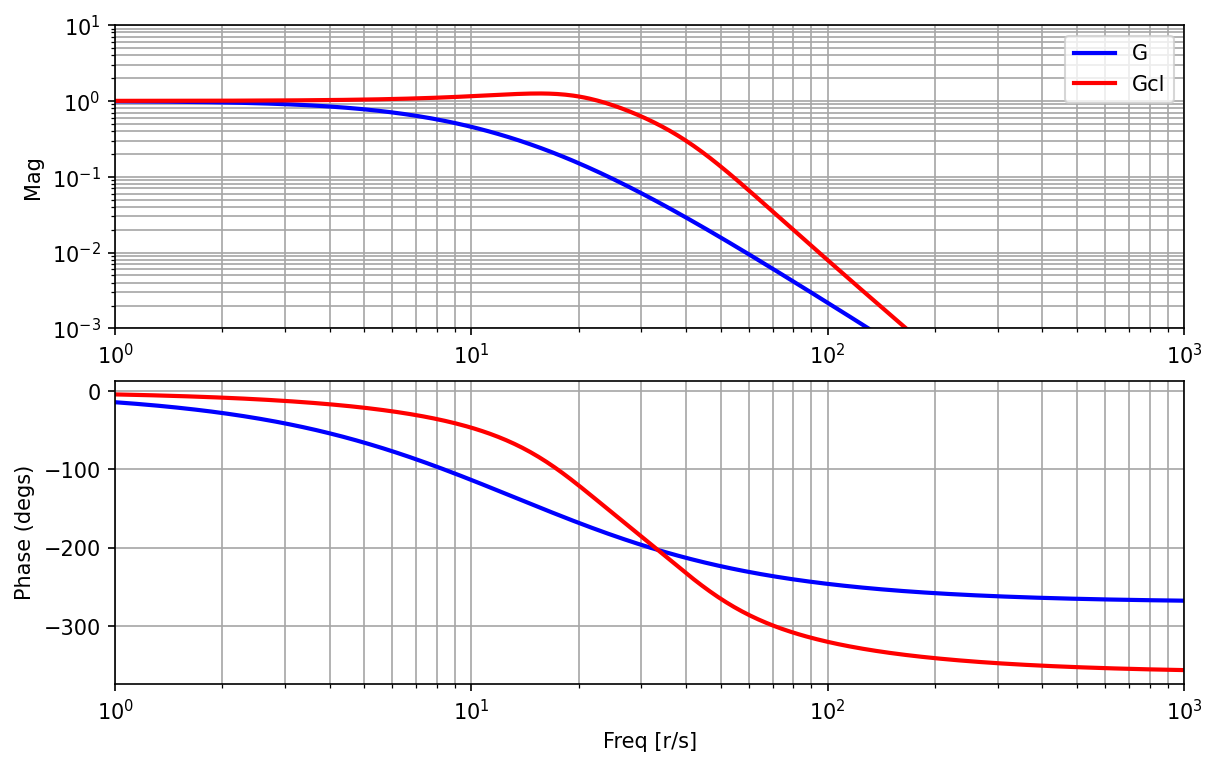

Closed-loop poles: (-20.00 + 34.64i), (-20.00 + -34.64i), -40.000, (-10.00 + 17.32i), (-10.00 + -17.32i), -20.000


In [6]:
G1 = ss(tf(8*14*20,np.convolve([1, 8],np.convolve([1, 14],[1, 20]))))
file_name = 'examp1'
nx = len(G1.poles())
zz,pp,kk = butter(nx,20,output='zpk',analog=True)
pe = [2*p for p in pp]
Gc1,Gcl1 = DOFB(G1,pp,pe,file_name=file_name, w=np.logspace(0,3,400))
pretty_row_print(Gcl1.poles(),"Closed-loop poles: ")


## <a id='toc2_2_'></a>[DOFB Example 2](#toc0_)

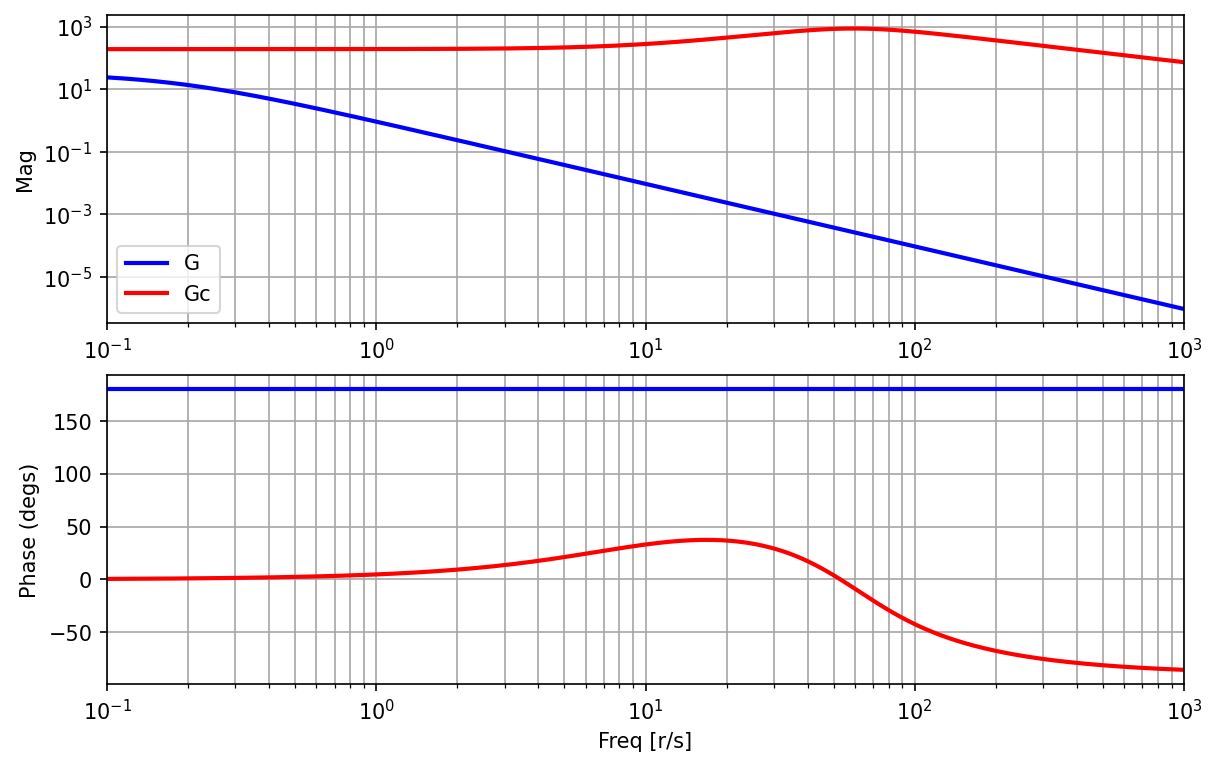

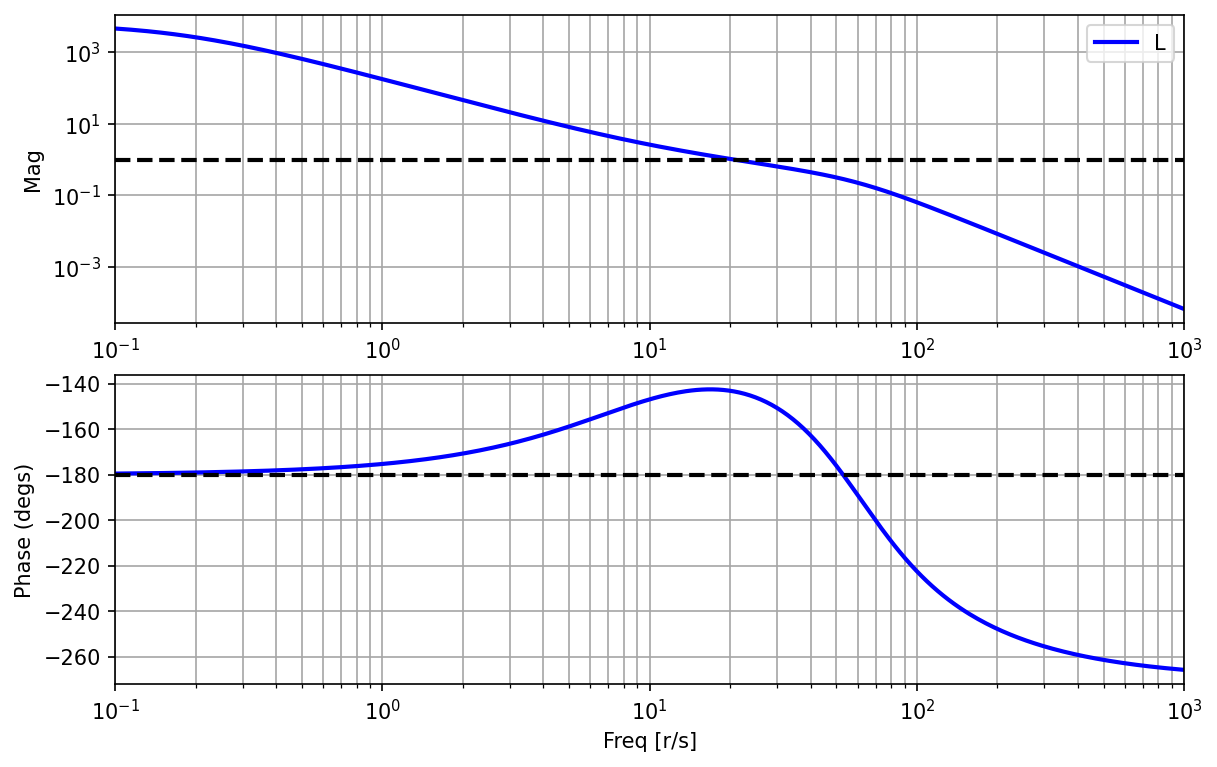

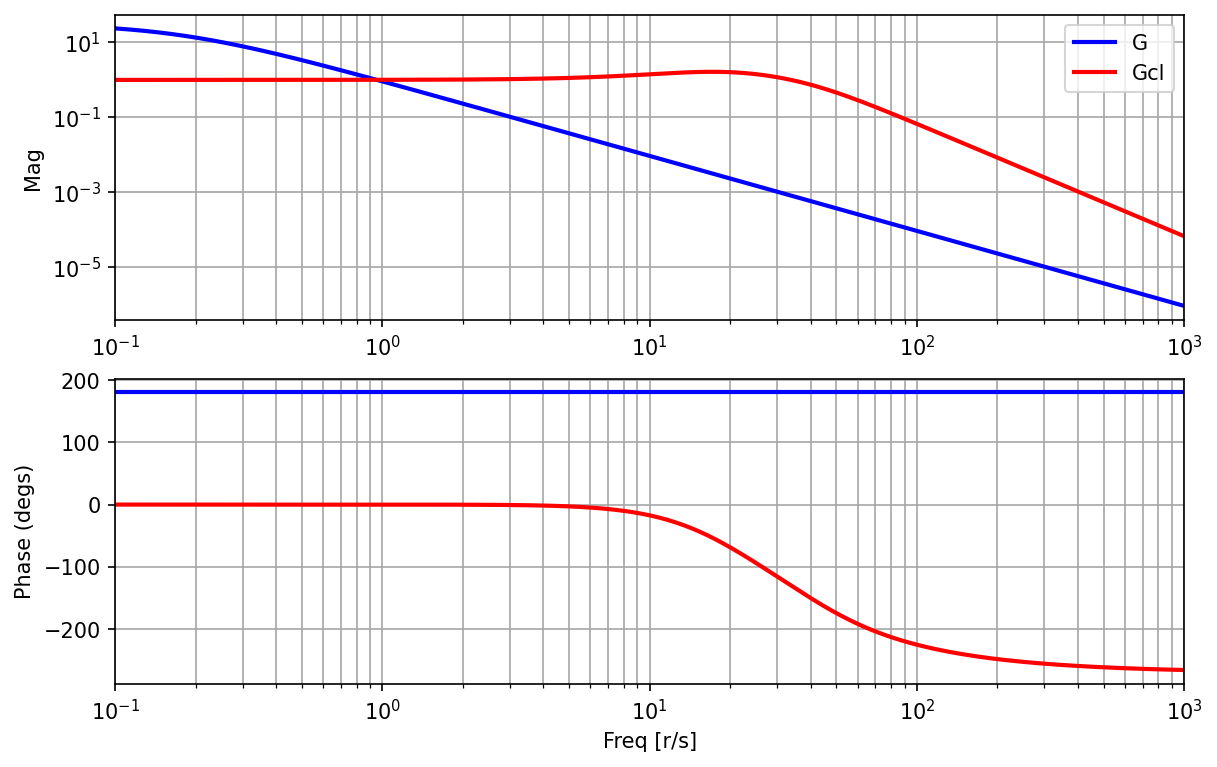

Closed-loop poles: (-28.28 + 28.28i), (-28.28 + -28.28i), (-14.14 + 14.14i), (-14.14 + -14.14i)


In [7]:
G2 = ss(tf(0.94,(1,0,-0.0297)))
file_name = 'examp2'
nx = len(G2.poles())
zz,pp,kk = butter(nx,20,output='zpk',analog=True)
pe = [2*p for p in pp]
Gc2,Gcl2 = DOFB(G2,pp,pe,file_name=file_name, w=np.logspace(-1,3,400),use_y_lims=False)
pretty_row_print(Gcl2.poles(),"Closed-loop poles: ")


## <a id='toc2_3_'></a>[DOFB Example 3](#toc0_)

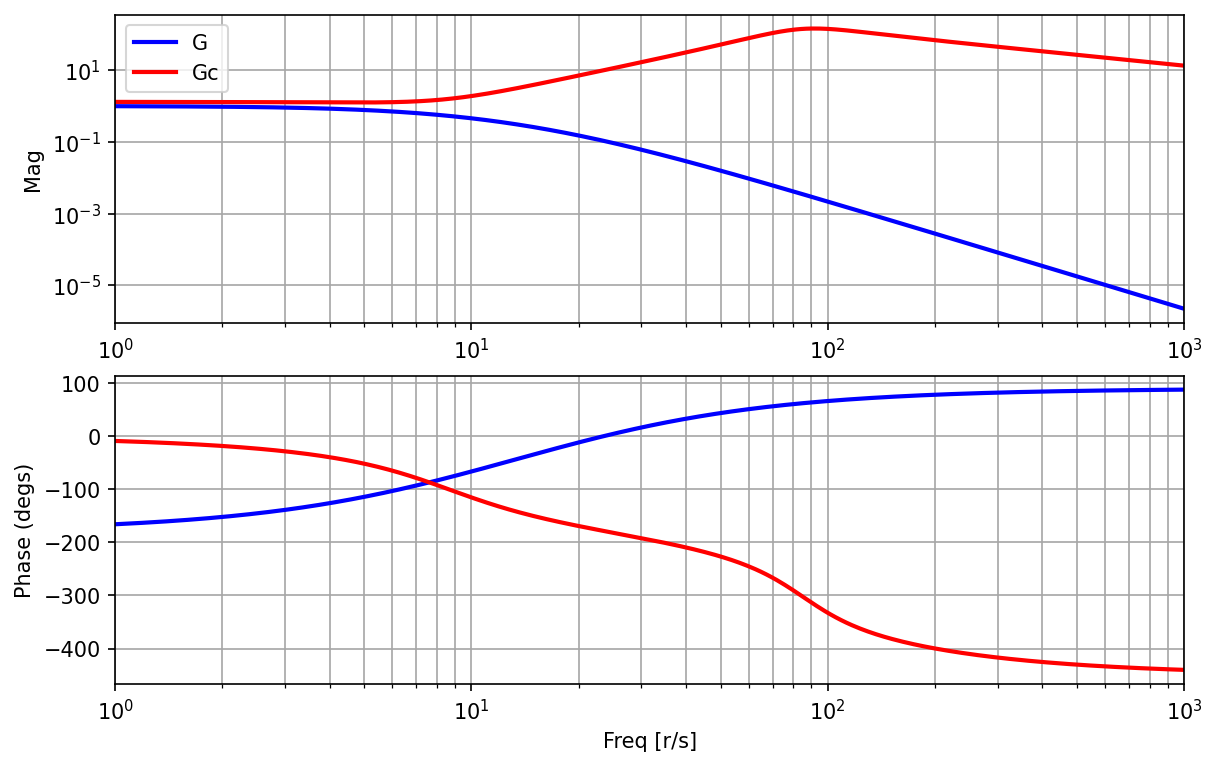

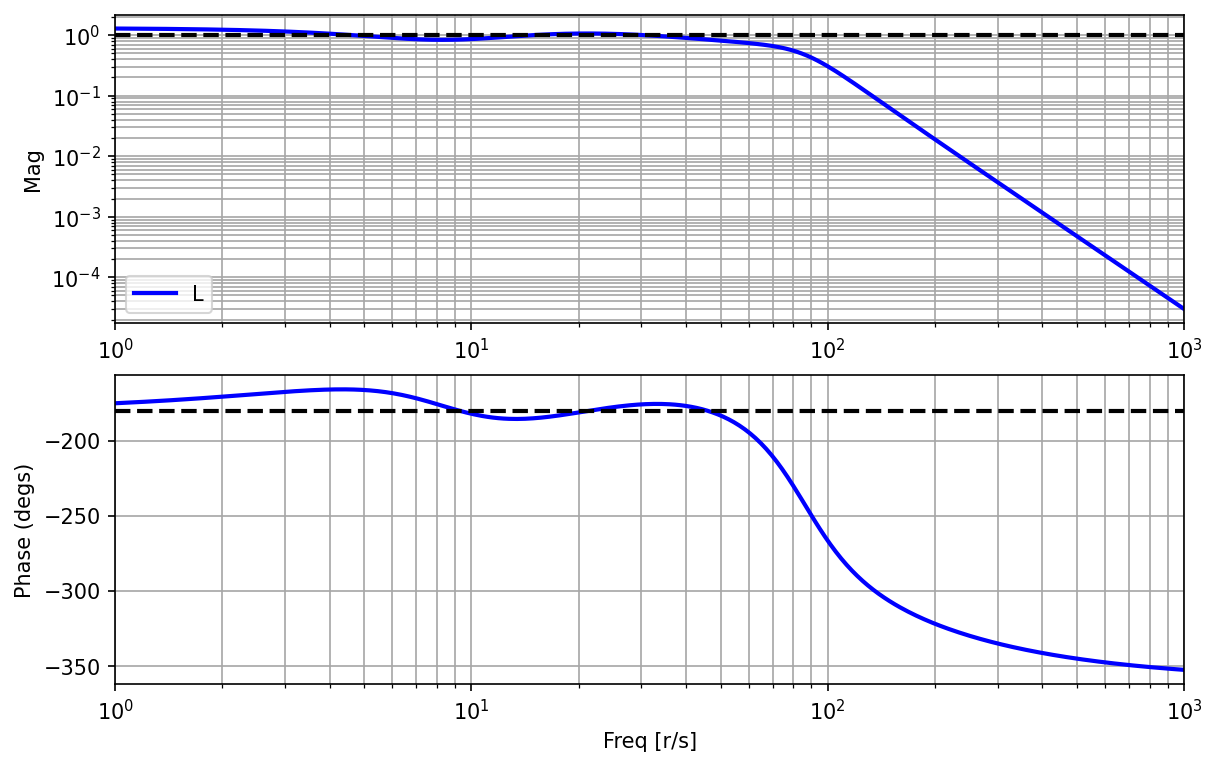

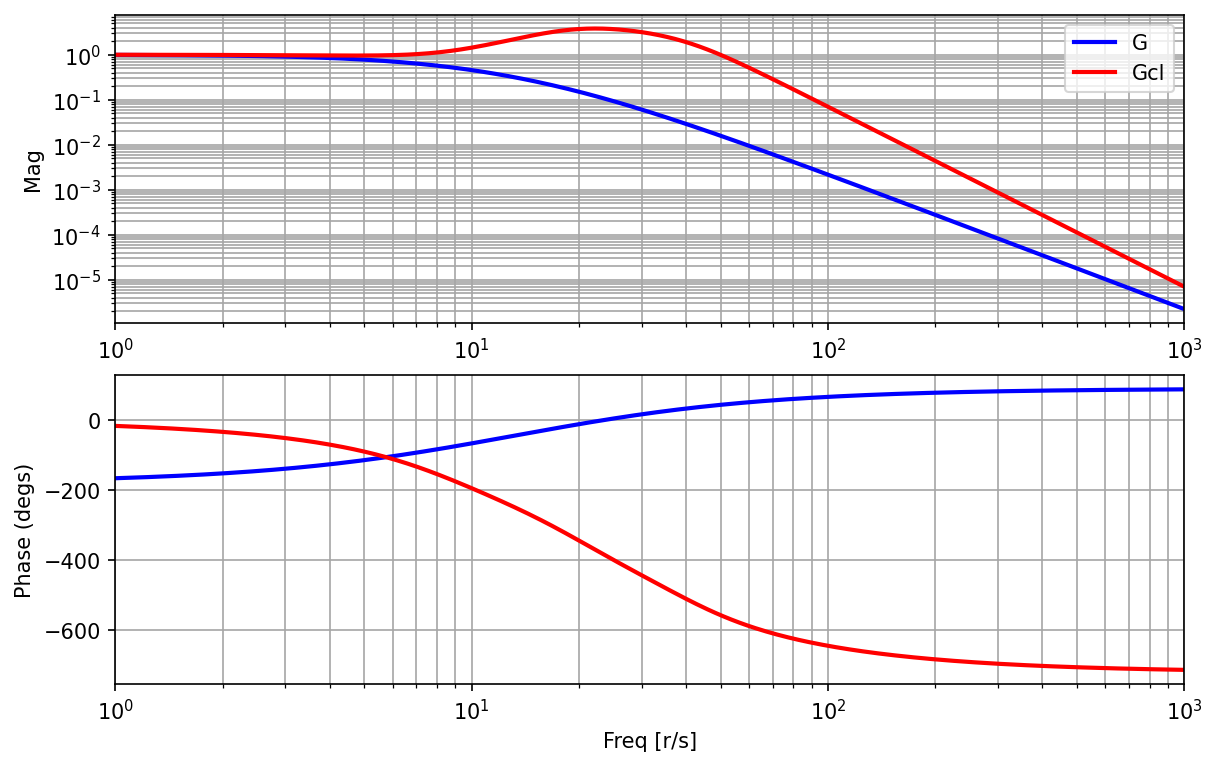

Closed-loop poles: (-20.00 + 34.64i), (-20.00 + -34.64i), -40.000, (-10.00 + 17.32i), (-10.00 + -17.32i), -20.000


In [8]:
G3 = ss(tf(8*14*20,np.convolve([1, -8],np.convolve([1, -14],[1, -20]))))
file_name = 'examp3'
nx = len(G3.poles())
zz,pp,kk = butter(nx,20,output='zpk',analog=True)
pe = [2*p for p in pp]
Gc3,Gcl3 = DOFB(G3,pp,pe,file_name=file_name, w=np.logspace(0,3,400),use_y_lims=False)
pretty_row_print(Gcl3.poles(),"Closed-loop poles: ")


## <a id='toc2_4_'></a>[DOFB Example 4](#toc0_)

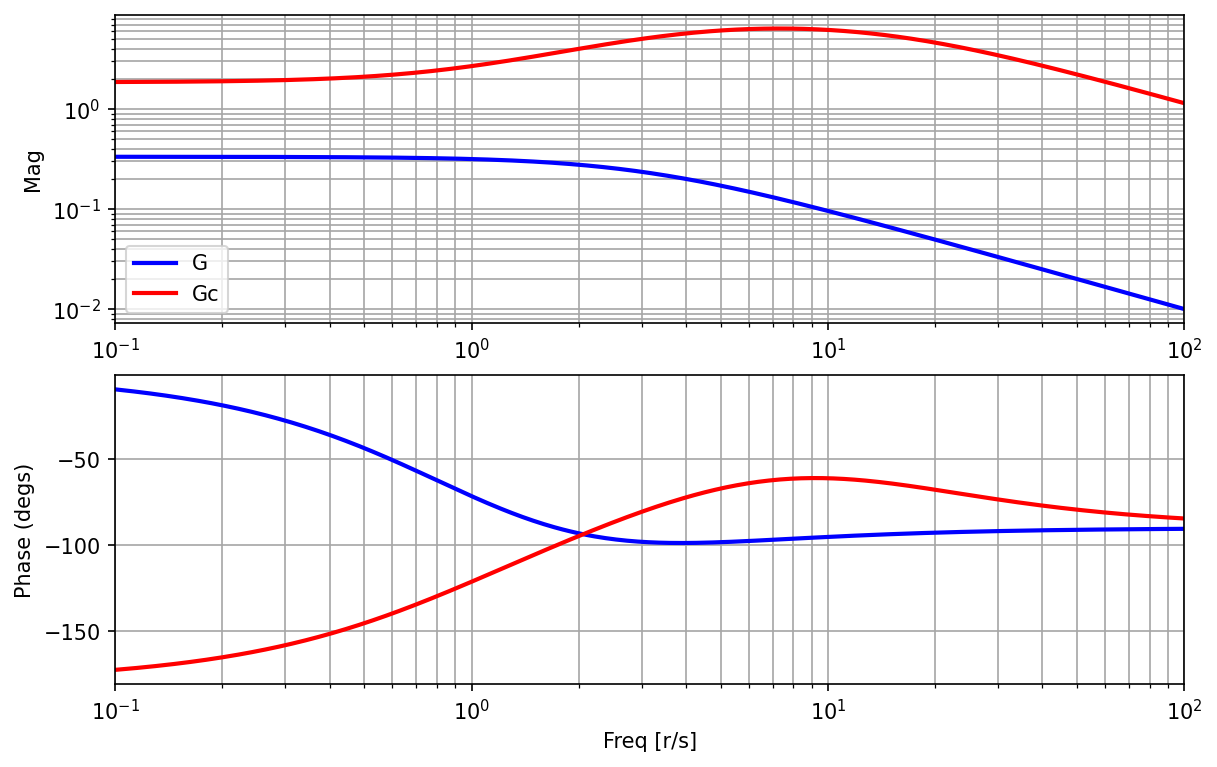

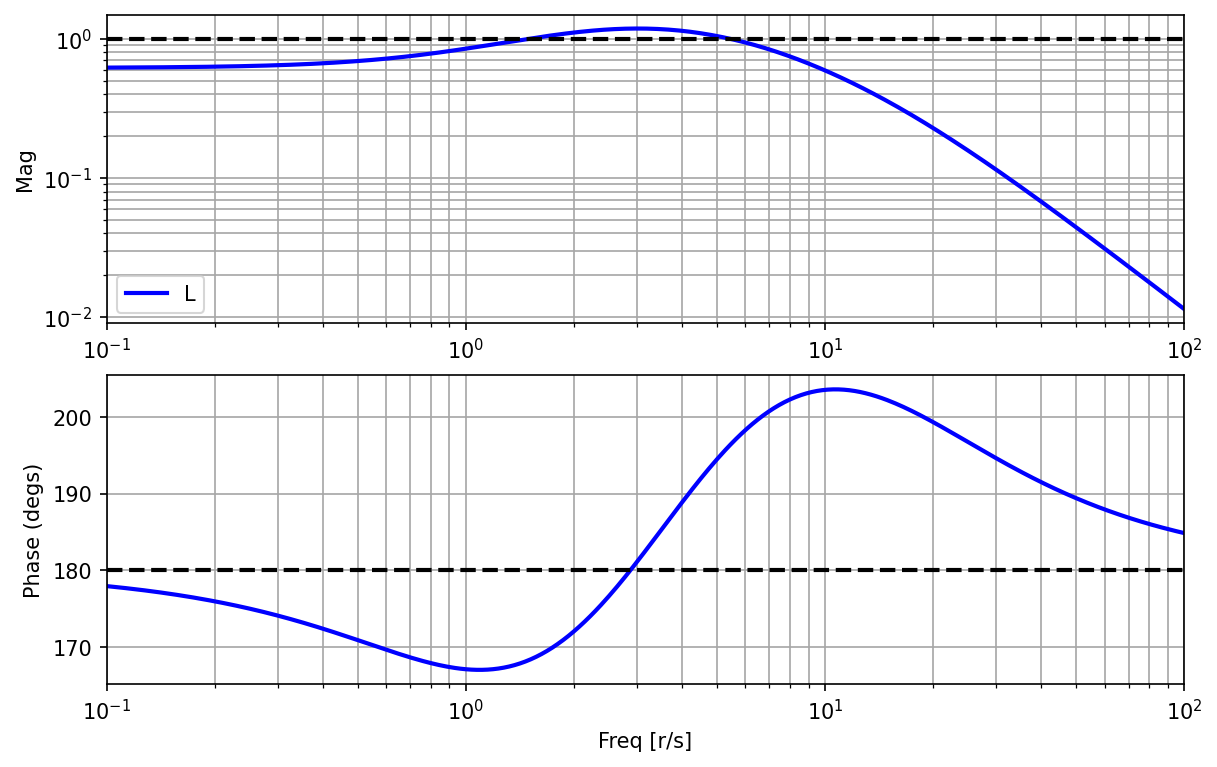

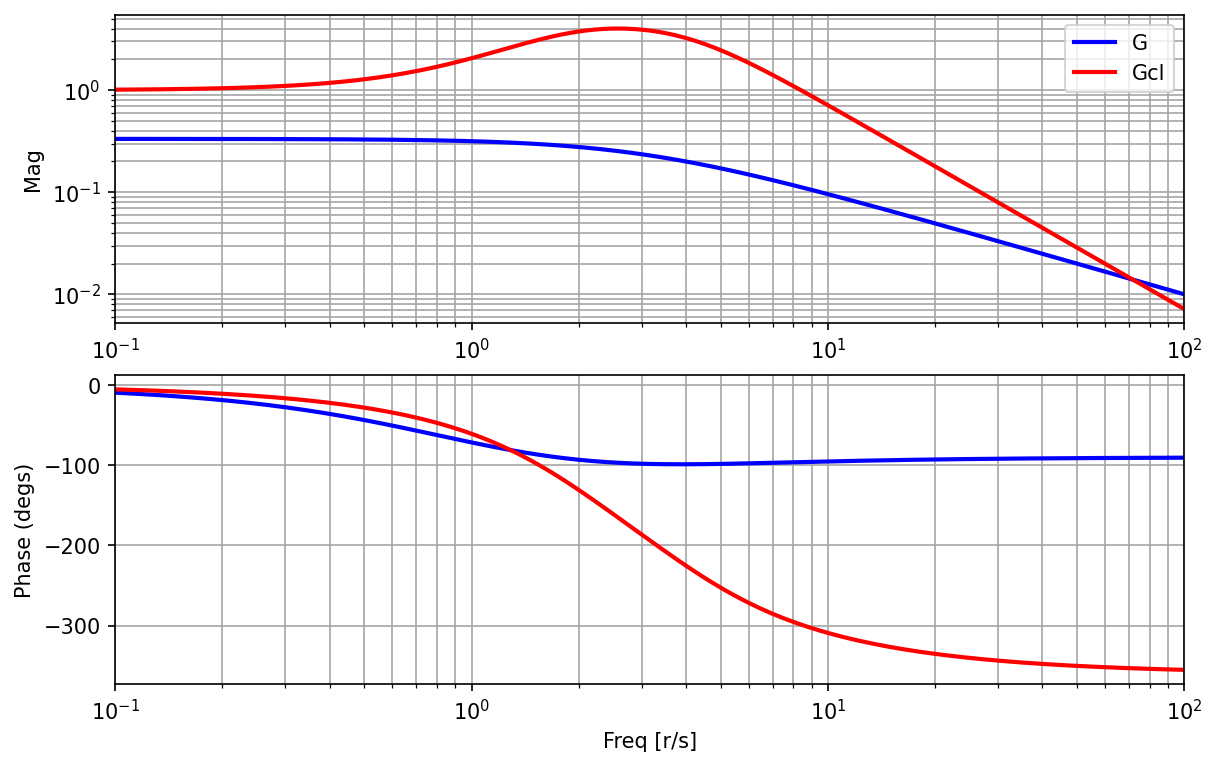

Closed-loop poles: (-2.83 + 2.83i), (-2.83 + -2.83i), (-1.41 + 1.41i), (-1.41 + -1.41i)


In [9]:
G4 = ss(tf((1,-1),(1,-2,-3)))
file_name = 'examp4'
nx = len(G4.poles())
zz,pp,kk = butter(nx,2,output='zpk',analog=True)
pe = [2*p for p in pp]
Gc4, Gcl4 = DOFB(G4,pp,pe,file_name=file_name, w=np.logspace(-1,2,400),use_y_lims=False)
pretty_row_print(Gcl4.poles(),"Closed-loop poles: ")
